In [ ]:
!pip install d2l

**Network in Network**  
The NiN block consists of one convolutional layer followed by two 1 × 1 convolutional layers that act
as per-pixel fully-connected layers with ReLU activations. 

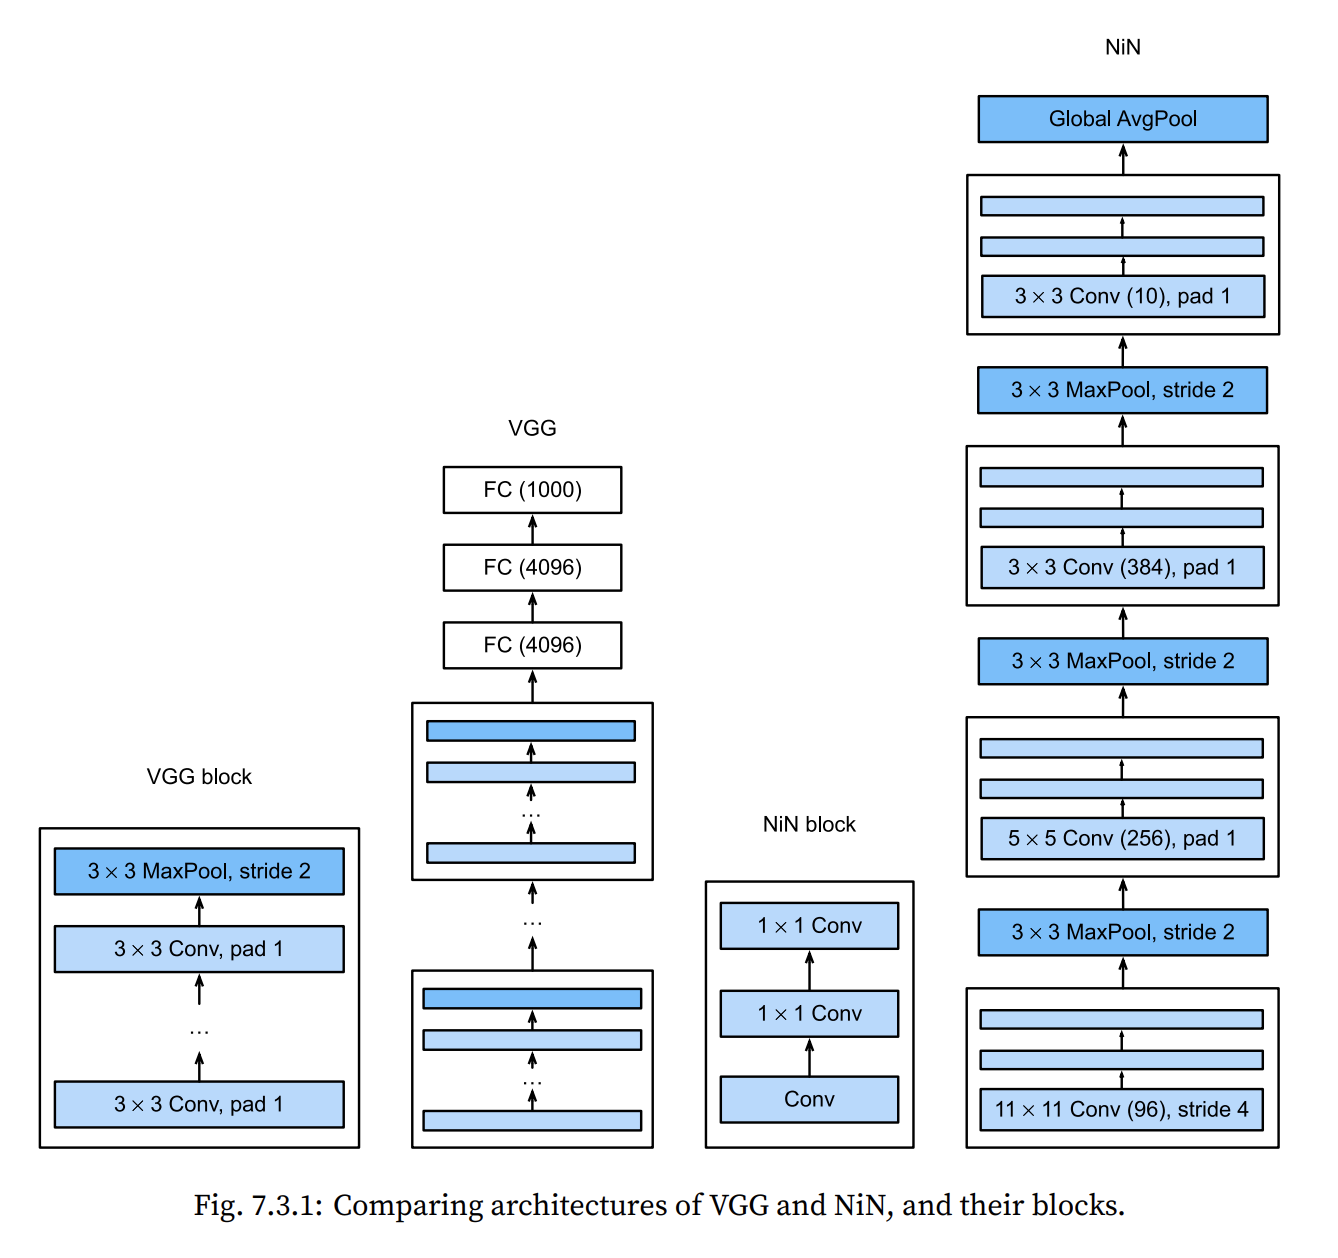

One significant difference between NiN and AlexNet is that NiN avoids fully-connected layers altogether. Instead, NiN uses an NiN block with a number of output channels equal to the number
of label classes, followed by a global average pooling layer, yielding a vector of logits. One **advantage** of NiNʼs design is that it significantly reduces the number of required model parameters.
However, in practice, this design sometimes requires increased model training time.

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
# define a NiN block
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
  )

In [ ]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(p=0.5),
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()

)

In [ ]:
X = torch.randn((1, 1, 224, 224))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'Output shape:', '\t', X.shape)

Sequential Output shape: 	 torch.Size([1, 96, 54, 54])
MaxPool2d Output shape: 	 torch.Size([1, 96, 26, 26])
Sequential Output shape: 	 torch.Size([1, 256, 26, 26])
MaxPool2d Output shape: 	 torch.Size([1, 256, 12, 12])
Sequential Output shape: 	 torch.Size([1, 384, 12, 12])
MaxPool2d Output shape: 	 torch.Size([1, 384, 5, 5])
Dropout Output shape: 	 torch.Size([1, 384, 5, 5])
Sequential Output shape: 	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d Output shape: 	 torch.Size([1, 10, 1, 1])
Flatten Output shape: 	 torch.Size([1, 10])


loss 0.396, train acc 0.851, test acc 0.859
1485.8 examples/sec on cuda:0


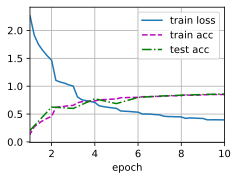

In [ ]:
# Training
batch_size, lr, num_epochs = 128, 0.1, 10
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**Summary**:
1. NiN uses blocks consisting of a convolutional layer and multiple 1 × 1 convolutional layers.
This can be used within the convolutional stack to allow for more per-pixel nonlinearity.
2. NiN removes the fully-connected layers and replaces them with global average pooling (i.e.,
summing over all locations) after reducing the number of channels to the desired number
of outputs (e.g., 10 for Fashion-MNIST).
3. Removing the fully-connected layers reduces overfitting. NiN has dramatically fewer parameters.
4. The NiN design influenced many subsequent CNN designs